In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import joblib

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from vecstack import stacking

In [2]:
data = pd.read_csv('../New_Aging_Survey/data/Lt08.csv')
data.head()

,pid,hhid,HHID20,CID20,ed,w08wgt_c,w08wgt_p,w01,w02,w03,...,w08G014,w08G026,w08G027,w08G028,w08G029,w08G030,w08G031,w08G032,w08Ba001,w08Ba002
0,11,1,10000000,11,833,1600.303883,2189.837105,1,1.0,1.0,...,NaN,80,60,NaN,60.0,70,4,20,1.0,NaN
1,21,2,20000000,21,833,3180.749884,3919.849664,1,1.0,1.0,...,NaN,50,40,60.0,50.0,30,5,10,1.0,NaN
2,22,2,20000000,21,833,4525.161503,5994.598161,1,1.0,1.0,...,NaN,60,50,60.0,NaN,60,4,20,1.0,NaN
3,41,4,40000000,41,833,1239.297401,1695.840060,1,1.0,1.0,...,NaN,70,60,60.0,70.0,60,5,10,1.0,NaN
4,42,4,40000000,41,833,1069.049862,1207.745056,1,1.0,1.0,...,NaN,60,60,70.0,NaN,60,6,5,1.0,NaN


In [3]:
# Gender, Age, Religion, Job, Married, Edu, Health, Self_conf, Earn, Activity
data['Earn_Score'] = data['w08hhinc'] / np.sqrt(data['w08hhsize'])
data['Earn'] = pd.qcut(data['Earn_Score'], 3, labels=[0, 1, 2])

index = data[data.Earn.isna()==True].index
data.drop(index, inplace=True)

data = data[(data['w08A002y'] >= 1955) & (data['w08A002y'] < 1964)]

data['Gender'] = np.where(data['w08gender1'] == 1, 1, 0)

data['Job'] = np.where(data['w08present_ecotype'] == 3, 0,
                        np.where(data['w08retired'].isin([1.0, 2.0]), 1,
                            np.where(data['w08job'].isin([1.0, 2.0]), 4,
                                    np.where(data['w08job'].isin([3.0, 6.0, 7.0, 8.0, -9.0]), 3,
                                            np.where(data['w08job'].isin([4.0, 5.0, 9.0]), 2,
                                                    np.where(data['w08emp'] == 2.0, 5, 6))))))
data['Edu'] = np.where(data['w08edu'] == 1, 3,
                        np.where(data['w08edu'] == 2, 2,
                                np.where(data['w08edu'] == 3, 1, 0)))

data['Health'] = np.where(data['w08C005'].isin([1,2]), 0,
                            np.where(data['w08C005'] == 3, 1, 2))

data['Self_conf_Score'] = data['w08G026'] + data['w08G027'] + data['w08G028'] + data['w08G029'] + data['w08G030']

data['Self_conf'] = pd.qcut(data['Self_conf_Score'], 3, labels=[0, 1, 2])

data['Age'] = data['w08A002_age']
data['Married'] = np.where(data['w08marital'] == 1, 1, 0)
data['w08A030'].replace(97, 6, inplace=True)
data['Religion'] = np.where(data['w08A030'] == 1, 0,
                        np.where(data['w08A030'] == 2, 2,
                                np.where(data['w08A030'] == 3, 3,
                                        np.where(data['w08A030'] == 4, 1,
                                                np.where(data['w08A030'] == 5, 5, 4)))))
data['Activity'] = data['w08A035_01'] + data['w08A035_02'] + data['w08A035_03'] + data['w08A035_04'] + data['w08A035_05'] + data['w08A035_06'] + data['w08A035_07']

data = data[['Gender', 'Age', 'Religion', 'Job', 'Married', 'Edu', 'Health', 'Self_conf', 'Earn', 'Activity']]

data['Activity'].fillna(0, inplace=True)
data['Self_conf'].fillna(1, inplace=True)

data['Self_conf'] = data.Self_conf.astype('int')
data['Earn'] = data.Earn.astype('int')

In [4]:
rf = joblib.load('./models/RandomForest_3.pkl')
xgb = joblib.load('./models/XGBoost_3.pkl')
lgb = joblib.load('./models/LGBoost_3.pkl')
cat = joblib.load('./models/CatBoost_3.pkl')

vot = joblib.load('./models/bayesian+softvot_3.pkl')

pred_rf = rf.predict_proba(data)
pred_xgb = xgb.predict_proba(data)
pred_lgb = lgb.predict_proba(data)
pred_cat = cat.predict_proba(data)

In [5]:
S_test = np.concatenate((pred_rf, pred_xgb, pred_lgb, pred_cat), axis=1)

In [15]:
model = joblib.load('./models/best_model_3.pkl')
pred = model.predict(S_test)

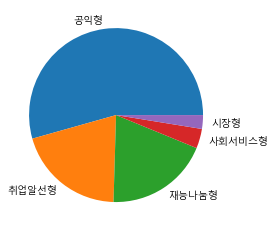

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

predict = pd.DataFrame({'pred':pred})
predict['pred'] = np.where(predict.pred == 1, '공익형',
                np.where(predict.pred == 2, '시장형',
                np.where(predict.pred == 3, '취업알선형',
                np.where(predict.pred == 4, '재능나눔형', '사회서비스형'))))
plt.pie(predict['pred'].value_counts(),labels= predict['pred'].value_counts().index)
plt.show()

In [18]:
predict['pred'].value_counts(normalize=True)

공익형       0.543714
취업알선형     0.201659
재능나눔형     0.192725
사회서비스형    0.036375
시장형       0.025526
Name: pred, dtype: float64

In [19]:
data['pred'] = pred
data[(data['pred']==3)&(data['Edu']==2)]

,Gender,Age,Religion,Job,Married,Edu,Health,Self_conf,Earn,Activity,pred
130,0,65,0,2,1,2,1,1,1,0.0,3
377,1,64,0,2,1,2,2,2,2,0.0,3
378,0,60,0,2,1,2,2,1,2,0.0,3
499,0,59,0,2,0,2,0,1,2,0.0,3
609,0,63,2,2,1,2,0,1,1,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...
5311,0,65,0,2,1,2,1,0,1,0.0,3
5390,0,63,1,2,1,2,1,1,1,0.0,3
5428,1,59,0,0,1,2,0,1,0,0.0,3
5431,0,59,0,2,0,2,1,1,1,0.0,3


In [26]:
# data = np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0].reshape(1, -1))
def Classification(data):
    pred_rf = rf.predict_proba(np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(1,-1))
    pred_xgb = xgb.predict_proba(np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(1,-1))
    pred_lgb = lgb.predict_proba(np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(1,-1))
    pred_cat = cat.predict_proba(np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(1,-1))

    S_test = np.concatenate((pred_rf, pred_xgb, pred_lgb, pred_cat), axis=1)

    pred = model.predict(S_test)

    return pred

In [27]:
Classification(np.array([0, 65, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(1, -1))

array([3], dtype=int64)